# Run Boostvqe in Quantinuum

Following our example in the notebook `gci_boostvqe_circuit_synthesis.ipynb`, we will load the VQE and GCI circuits and run on Quantinuum Nexus emulators.

## Load VQE and GCI circuits

In [1]:
from pytket import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter
import pytket.qasm
from datetime import datetime
from quantinuum_utils import *

In [2]:
import os
os.chdir('..')
optimizer = 'sgd'
nqubits = 4
nlayer = 1
folder_path = f'results/circuit_qasm/{optimizer}_{nqubits}q_{nlayer}l_XXZ/'
vqe_circ_file = folder_path + 'vqe_circ_step1.qasm'
gci_circ_file = folder_path + 'gci_circ_step1.qasm'

In [3]:
vqe_circ = pytket.qasm.circuit_from_qasm(vqe_circ_file)
# render_circuit_jupyter(vqe_circ)

In [4]:
gci_circ = pytket.qasm.circuit_from_qasm(gci_circ_file)
# render_circuit_jupyter(gci_circ)

# Quantinuum preparation

Let us check the size of the GCI circuit.

In [5]:
print("Circuit depth:", gci_circ.depth())
print("Circuit total gate count:", gci_circ.n_gates)
num_cnots = sum(1 for command in gci_circ if command.op.type == OpType.CX)
print("Circuit CNOT count:", num_cnots)

Circuit depth: 127
Circuit total gate count: 376
Circuit CNOT count: 48


In [6]:
import qnexus as qnx

In [7]:
# connect to nexus account
qnx.client.auth.login()

🌐 Browser log in initiated.


╭────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                        │
│         Confirm that the browser shows the following code and click 'allow device':    │
│                                                                                        │
│                                      Ji3ROA                                            │
│                                                                                        │
╰────────────────────────────────────────────────────────────────────────────────────────╯

Browser didn't open automatically? Use this link: https://nexus.quantinuum.com/auth/device/browser?otp=Ji3ROAtp0JEicYKJMXUTbM3sbA2761nl8HBset7_G4ZeTCx3YRgBU7khLs5ctrAI4LkUyb6D-H3sIx3tDwjnPg
✅ Successfully logged in as xiaoyue.li@ntu.edu.sg using the browser.


In [8]:
# connect to nexus project
project_name = "boostvqe_demo_XXZ"
project_ref = qnx.projects.get_or_create(name=project_name)
project_ref.df()

# set this in the context
qnx.context.set_active_project(project_ref)

### Hamiltonian in Pytket

In [9]:
# XXZ model
nqubits = 4
delta = 0.5
terms = {}
for i in range(nqubits):
    term_x_i = create_qubit_pauli_string(nqubits, {i: Pauli.X, (i+1)%nqubits: Pauli.X}, 1)
    term_y_i = create_qubit_pauli_string(nqubits, {i: Pauli.Y, (i+1)%nqubits: Pauli.Y}, 1)
    term_z_i = create_qubit_pauli_string(nqubits, {i: Pauli.Z, (i+1)%nqubits: Pauli.Z}, delta)
    terms.update(term_x_i)
    terms.update(term_y_i)
    terms.update(term_z_i)
ham_quantinuum = QubitPauliOperator(terms)

### Measurement setup
Based on the hamiltonian in Pauli basis, we create a list of measurement setup for evaluating each non-commuting set of Pauli components of the hamiltonian.

In [10]:
terms = [term for term in ham_quantinuum._dict.keys()]
measurement_setup = measurement_reduction(
    terms, strat=PauliPartitionStrat.CommutingSets
)
# for mc in measurement_setup.measurement_circs:
#     render_circuit_jupyter(mc)

Here, we have created measurement circuits for the $X$, $Y$, and $Z$ terms. Next, we can upload and compile the measurement circuits.

## Compile circuits

We are now running noiseless emulation.

In [11]:
optimisation_level = 2

In [12]:
# create list of circuits for measurement in different bases
vqe_circuit_ref_list = []
gci_circuit_ref_list = []
for i, mc in enumerate(measurement_setup.measurement_circs):
    c = vqe_circ.copy()
    c.append(mc)
    measurement_vqe_circuit_ref = qnx.circuits.upload(
                circuit=c, 
                name=f"measurement vqe circuit {i}",
            )
    c = gci_circ.copy()
    c.append(mc)
    measurement_gci_circuit_ref = qnx.circuits.upload(
                circuit=c, 
                name=f"measurement gci circuit {i}",
            )
    vqe_circuit_ref_list.append(measurement_vqe_circuit_ref)
    gci_circuit_ref_list.append(measurement_gci_circuit_ref)

# compile vqe measurement circuit list
compiled_vqe_circuit_refs = qnx.compile(
            name=f"compile_job_VQE_{datetime.now()}",
            circuits=vqe_circuit_ref_list,
            optimisation_level=optimisation_level,
            backend_config=qnx.QuantinuumConfig(device_name="H1-1LE"),
            timeout=None,
        )

# compile gci measurement circuit list
compiled_gci_circuit_refs = qnx.compile(
            name=f"compile_job_GCI_{datetime.now()}",
            circuits=gci_circuit_ref_list,
            optimisation_level=optimisation_level,
            backend_config=qnx.QuantinuumConfig(device_name="H1-1LE"),
            timeout=None,
        )

# Run without noise

In [74]:
# Configuration
nshots = 2000
backend_config = qnx.QuantinuumConfig(device_name="H1-1LE") 

In [83]:
vqe_job_name = f"execute_job_VQE_{nshots}shots_{datetime.now()}"
gci_job_name = f"execute_job_GCI_{nshots}shots_{datetime.now()}"
results_vqe = qnx.start_execute_job(
            name=vqe_job_name,
            circuits=compiled_vqe_circuit_refs,
            n_shots=[nshots]*len(vqe_circuit_ref_list),
            backend_config=backend_config,
        )
results_gci = qnx.start_execute_job(
            name=gci_job_name,
            circuits=compiled_gci_circuit_refs,
            n_shots=[nshots]*len(gci_circuit_ref_list),
            backend_config=backend_config,
        )

In [84]:
from pathlib import Path
folder_path = f'results/qnx_job_ref/{optimizer}_{nqubits}q_{nlayer}l_{optimisation_level}ol_XXZ/'
os.makedirs(folder_path, exist_ok=True)
qnx.filesystem.save(
    ref=results_vqe,
    path=Path.cwd() / folder_path / vqe_job_name,
    mkdir=True,
)

from pathlib import Path
qnx.filesystem.save(
    ref=results_gci,
    path=Path.cwd() /folder_path / gci_job_name,
    mkdir=True,
)

# Retrieve noiseless results

Without running repeated jobs, we can retrieve our results from the Qnexus project.

In [22]:
print(qnx.jobs.status(results_vqe))
print(qnx.jobs.status(results_gci))

JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2024, 11, 20, 2, 27, 7, 585406, tzinfo=datetime.timezone.utc), queued_time=None, submitted_time=datetime.datetime(2024, 11, 20, 2, 24, 6, 841039, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2024, 11, 20, 2, 27, 1, 388992, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)
JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2024, 11, 20, 2, 27, 10, 795352, tzinfo=datetime.timezone.utc), queued_time=None, submitted_time=datetime.datetime(2024, 11, 20, 2, 24, 7, 136623, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2024, 11, 20, 2, 27, 7, 877413, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=Non

In [23]:
vqe_results = [job.download_result() for job in qnx.jobs.results(results_vqe)]
gci_results = [job.download_result() for job in qnx.jobs.results(results_gci)]

In [24]:
expval_vqe = compute_expectation_value_from_results(
    vqe_results, measurement_setup, ham_quantinuum
)
print(expval_vqe)

-6.323


In [25]:
expval_gci = compute_expectation_value_from_results(
    gci_results, measurement_setup, ham_quantinuum
)
print(expval_gci)

-6.623999999999999


# With noise

In [49]:
backend_config = qnx.QuantinuumConfig(
    device_name='H1-Emulator',
    attempt_batching=True,
)
nshots = 2000

In [72]:
vqe_job_name_with_noise = f"execute_job_VQE_{nshots}shots_noise_{datetime.now()}"
gci_job_name_with_noise = f"execute_job_GCI_{nshots}shots_noise_{datetime.now()}"
results_vqe_noise = qnx.start_execute_job(
            name=vqe_job_name_with_noise,
            circuits=compiled_vqe_circuit_refs,
            n_shots=[nshots]*len(vqe_circuit_ref_list),
            backend_config=backend_config,
        )
results_gci_noise = qnx.start_execute_job(
            name=gci_job_name_with_noise,
            circuits=compiled_gci_circuit_refs,
            n_shots=[nshots]*len(gci_circuit_ref_list),
            backend_config=backend_config,
        )

In [73]:
from pathlib import Path
folder_path = f'results/qnx_job_ref/{optimizer}_{nqubits}q_{nlayer}l_{optimisation_level}ol_XXZ/'
os.makedirs(folder_path, exist_ok=True)
qnx.filesystem.save(
    ref=results_vqe_noise,
    path=Path.cwd() / folder_path / vqe_job_name_with_noise,
    mkdir=True,
)

from pathlib import Path
qnx.filesystem.save(
    ref=results_gci_noise,
    path=Path.cwd() / folder_path / gci_job_name_with_noise,
    mkdir=True,
)

# Retrieve noisy results

In [ ]:
print(qnx.jobs.status(results_vqe_noise))
print(qnx.jobs.status(results_gci_noise))

JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2024, 11, 19, 7, 42, 43, 989978, tzinfo=datetime.timezone.utc), queued_time=None, submitted_time=datetime.datetime(2024, 11, 19, 7, 42, 40, 957882, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2024, 11, 19, 7, 42, 41, 653110, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_position=None)
JobStatus(status=<StatusEnum.COMPLETED: 'Circuit has completed. Results are ready.'>, message='The job is completed.', error_detail=None, completed_time=datetime.datetime(2024, 11, 19, 7, 42, 57, 380991, tzinfo=datetime.timezone.utc), queued_time=None, submitted_time=datetime.datetime(2024, 11, 19, 7, 42, 41, 280360, tzinfo=datetime.timezone.utc), running_time=datetime.datetime(2024, 11, 19, 7, 42, 44, 660004, tzinfo=datetime.timezone.utc), cancelled_time=None, error_time=None, queue_positio

In [ ]:
vqe_results_noise = [job.download_result() for job in qnx.jobs.results(results_vqe_noise)]
gci_results_noise = [job.download_result() for job in qnx.jobs.results(results_gci_noise)]

In [ ]:
expval_vqe_noise = compute_expectation_value_from_results(
    vqe_results_noise, measurement_setup, ham_quantinuum
)
print(expval_vqe_noise)

-6.217


In [ ]:
expval_gci_noise = compute_expectation_value_from_results(
    gci_results_noise, measurement_setup, ham_quantinuum
)
print(expval_gci_noise)

-6.468999999999999


# Prepare report

In [ ]:
import qibo
from qibo.backends import construct_backend
from qibo import hamiltonians
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
qibo.set_backend("numpy")

[Qibo 0.2.13|INFO|2024-11-19 15:43:27]: Using numpy backend on /CPU:0


[Qibo 0.2.13|WARNING|2024-11-19 15:43:28]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


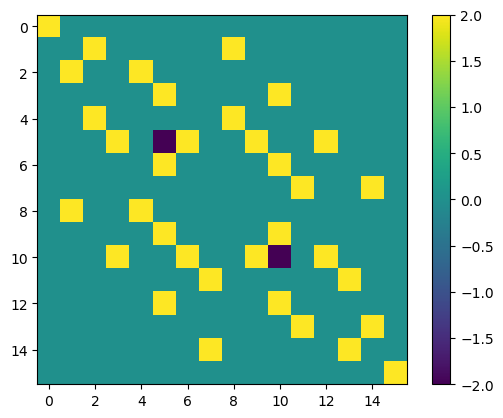

In [ ]:
nqubits = 4
delta = 0.5
ham = hamiltonians.XXZ(nqubits, delta, dense=False)
plt.imshow(np.real(ham.matrix))
plt.colorbar()

In [ ]:
with open (vqe_circ_file, "r") as file:
    vqe_circuit_qasm_str = file.read()
    
with open (gci_circ_file, "r") as file:
    gci_circuit_qasm_str = file.read()

In [ ]:
vqe_circ_qibo = qibo.models.Circuit.from_qasm(vqe_circuit_qasm_str)
gci_circ_qibo = qibo.models.Circuit.from_qasm(gci_circuit_qasm_str)

In [ ]:
report_quantinuum = report(vqe_circ_qibo, gci_circ_qibo, ham, expval_vqe, expval_gci, expval_vqe_noise, expval_gci_noise)

In [ ]:
report_table(report_quantinuum)

,Analytical,Emulator,Emulator with Noise
VQE energy,-6.309812,-6.333500,-6.217000
GCI energy,-6.654477,-6.534500,-6.469000
Difference to target (VQE),0.434751,0.411063,0.527563
Difference to target (GCI),0.090085,0.210063,0.275563
Percentage difference to target (VQE),6.445942,6.094726,7.822044
Percentage difference to target (GCI),1.335674,3.114548,4.085701
Fidelity witness (VQE),0.841596,0.850227,0.807779
Fidelity witness (GCI),0.967177,0.923462,0.899597
